Mounted at /content/drive
Current working directory: /content/drive/My Drive/TESI
Pickle file loaded successfully.
Total samples in dataset: 1997


preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

Example audio shape: (59894,)


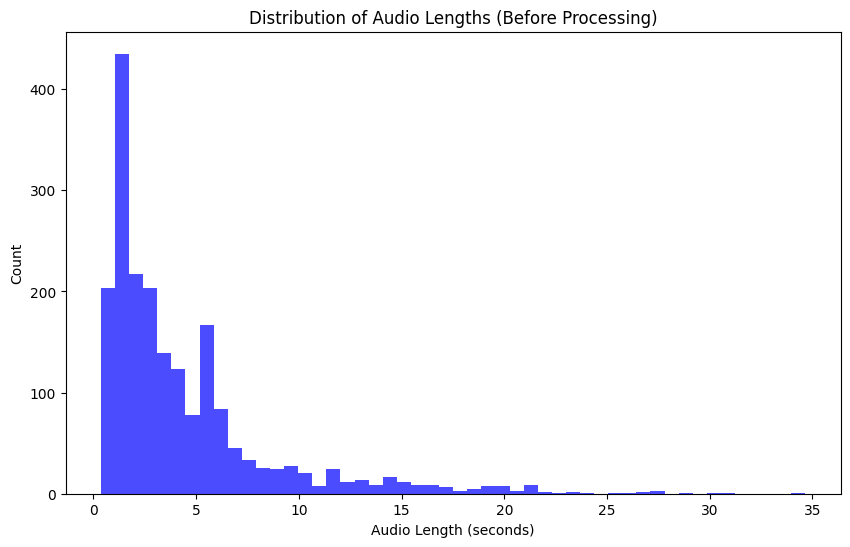

Number of audios: 1997
Minimum audio length: 0.36 seconds
Maximum audio length: 34.66 seconds


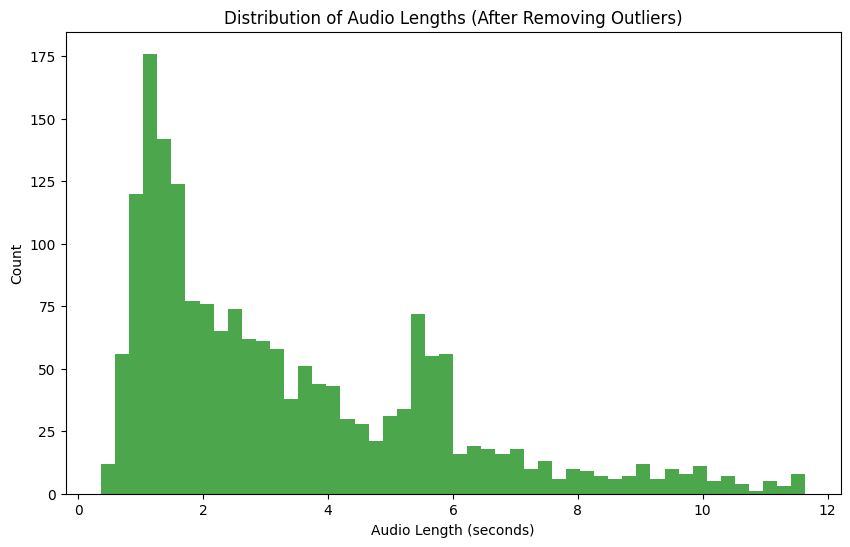

Number of audios after removing outliers: 1841
Minimum audio length after filtering: 0.36 seconds
Maximum audio length after filtering: 11.64 seconds
The shortest audio length is: 0.36 seconds (15872 samples)
Distribution BEFORE outlier removal:
Number of controls: 966
Number of Parkinsonians: 1031
UPDRS Distribution:
  UPDRS 0: 118
  UPDRS 1: 98
  UPDRS 2: 65
  UPDRS 3: 5
  UPDRS 4: 20
Distribution AFTER outlier removal:
Number of controls: 918
Number of Parkinsonians: 923
UPDRS Distribution:
  UPDRS 0: 73
  UPDRS 1: 69
  UPDRS 2: 38
  UPDRS 3: 5
  UPDRS 4: 19
Processing audios and creating first and last halves...
All audios have been processed and divided into first and last halves.


In [1]:
# ==== SECTION 0: Import Libraries and Mount Google Drive ====

# Import necessary standard libraries
import os  # For operating system dependent functionality
import pickle  # For serializing and de-serializing Python objects
import random  # For generating random numbers
import numpy as np  # For numerical operations on arrays
import pandas as pd

# Import PyTorch libraries for deep learning
import torch  # Main PyTorch library
import torch.optim as optim  # Optimization algorithms
import torch.nn as nn  # Neural network modules
import matplotlib.pyplot as plt  # For plotting graphs

# Import utilities for data handling
from torch.utils.data import Dataset, DataLoader  # For creating custom datasets and data loaders
from sklearn.metrics import (
    roc_curve, auc, accuracy_score, precision_score, recall_score,
    f1_score, balanced_accuracy_score, confusion_matrix
)  # For evaluating model performance

# Import transformers library for AST
from transformers import ASTFeatureExtractor, ASTForAudioClassification  # AST models and feature extractor

# Import defaultdict for grouping data
from collections import defaultdict  # For creating dictionaries with default values

# Import Google Colab drive for accessing Google Drive
from google.colab import drive  # To mount Google Drive

# Additional libraries for audio processing and image handling
import librosa  # For audio processing
import cv2  # For image processing
from torchvision import transforms  # For data augmentation and transformations

# ==== Mount Google Drive to access the dataset ====
drive.mount('/content/drive')  # Mount Google Drive at the specified path

# ==== SECTION 1: Data Loading and Preprocessing ====

# Set the path to your thesis directory in Google Drive
tesi_path = '/content/drive/My Drive/TESI'  # Define the path to the thesis directory
os.chdir(tesi_path)  # Change the current working directory to the thesis directory
print("Current working directory:", os.getcwd())  # Print the current working directory

# Define the path to the pickle file containing the dataset
file_path = '/content/drive/MyDrive/TESI/newdata_updated.pkl'  # Path to the pickle file

# Load the dataset from the pickle file
with open(file_path, 'rb') as f:
    newdata = pickle.load(f)  # Deserialize the pickle file into 'newdata'

print("Pickle file loaded successfully.")  # Confirm successful loading
print(f"Total samples in dataset: {len(newdata)}")  # Print the number of samples in the dataset

# Initialize the AST feature extractor with pretrained weights
feature_extractor = ASTFeatureExtractor.from_pretrained(
    'MIT/ast-finetuned-audioset-10-10-0.4593',  # Pretrained AST model
    sampling_rate=16000,  # Set the audio sampling rate to 16kHz
    return_attention_mask=False  # Do not return attention masks
)

# Normalize the audio data to ensure it lies within the [-1, 1] range
for item in newdata:
    audio = np.array(item['audio'])  # Convert audio data to a NumPy array
    audio = audio / np.max(np.abs(audio))  # Normalize audio to [-1, 1]
    item['audio'] = audio  # Update the audio data in the dataset

# Debugging: Print the shape of the first sample's audio
print(f"Example audio shape: {newdata[0]['audio'].shape}")  # Shape of the first audio sample

# ==== SECTION 2: Data Splitting and Outlier Removal ====

def print_updrs_distribution(data, label_key='label', updrs_keys=['updrs', 'UPDRS']):
    """
    Prints the distribution of data based on UPDRS levels and labels.

    Args:
        data (list): Dataset containing 'label' and 'updrs' or 'UPDRS' information.
        label_key (str): Key for the label (0 = control, 1 = Parkinsonian).
        updrs_keys (list): Possible keys for the UPDRS value in the data.
    """
    # Counters for labels and UPDRS
    updrs_counts = defaultdict(int)
    control_count, parkinsonian_count = 0, 0

    for item in data:
        # Check for the presence of the label key
        if label_key in item:
            label = item[label_key]
            if label == 0:
                control_count += 1
            elif label == 1:
                parkinsonian_count += 1

        # Check for the presence of at least one UPDRS key
        updrs_value = None
        for key in updrs_keys:
            if key in item:
                updrs_value = item[key]
                break

        # Increment the count for the UPDRS level
        if updrs_value is not None:
            updrs_counts[updrs_value] += 1

    # Print results
    print(f"Number of controls: {control_count}")
    print(f"Number of Parkinsonians: {parkinsonian_count}")
    print("UPDRS Distribution:")
    for updrs_value, count in sorted(updrs_counts.items()):
        print(f"  UPDRS {updrs_value}: {count}")


# Define the standard audio sampling rate for processing
sampling_rate = 44100  # Set sampling rate to 16kHz

# Calculate audio lengths in samples and convert to seconds for analysis
audio_lengths = [len(item['audio']) for item in newdata]  # List of audio lengths in samples
audio_lengths_sec = [length / sampling_rate for length in audio_lengths]  # Convert lengths to seconds

# Plot the distribution of audio lengths before processing
plt.figure(figsize=(10, 6))  # Set figure size
plt.hist(audio_lengths_sec, bins=50, color='blue', alpha=0.7)  # Create a histogram of audio lengths
plt.title('Distribution of Audio Lengths (Before Processing)')  # Set plot title
plt.xlabel('Audio Length (seconds)')  # Set x-axis label
plt.ylabel('Count')  # Set y-axis label
plt.show()  # Display the plot

# Print statistics about the audio lengths
print(f"Number of audios: {len(audio_lengths_sec)}")  # Total number of audio samples
print(f"Minimum audio length: {min(audio_lengths_sec):.2f} seconds")  # Minimum audio length
print(f"Maximum audio length: {max(audio_lengths_sec):.2f} seconds")  # Maximum audio length

# Remove outliers based on audio length using the Interquartile Range (IQR) method
q1 = np.percentile(audio_lengths, 25)  # First quartile
q3 = np.percentile(audio_lengths, 75)  # Third quartile
iqr = q3 - q1  # Interquartile range

# Define acceptable range for audio lengths
lower_bound = q1 - 1.5 * iqr  # Lower bound for acceptable lengths
upper_bound = q3 + 1.5 * iqr  # Upper bound for acceptable lengths

# Filter audios within the acceptable range
filtered_data = [item for item in newdata if lower_bound <= len(item['audio']) <= upper_bound]  # Remove outliers

# Extract lengths after filtering
filtered_audio_lengths = [len(item['audio']) for item in filtered_data]  # Lengths after filtering
filtered_audio_lengths_sec = [length / sampling_rate for length in filtered_audio_lengths]  # Convert to seconds

# Plot the distribution after filtering
plt.figure(figsize=(10, 6))  # Set figure size
plt.hist(filtered_audio_lengths_sec, bins=50, color='green', alpha=0.7)  # Create a histogram
plt.title('Distribution of Audio Lengths (After Removing Outliers)')  # Set plot title
plt.xlabel('Audio Length (seconds)')  # Set x-axis label
plt.ylabel('Count')  # Set y-axis label
plt.show()  # Display the plot

# Print statistics after filtering
print(f"Number of audios after removing outliers: {len(filtered_audio_lengths_sec)}")  # Number after filtering
print(f"Minimum audio length after filtering: {min(filtered_audio_lengths_sec):.2f} seconds")  # New minimum
print(f"Maximum audio length after filtering: {max(filtered_audio_lengths_sec):.2f} seconds")  # New maximum

# Find the shortest audio length (n) in samples
min_length = min(filtered_audio_lengths)  # Minimum length in samples
print(f"The shortest audio length is: {min_length / sampling_rate:.2f} seconds ({min_length} samples)")  # Print shortest length


# Before removing outliers
print("Distribution BEFORE outlier removal:")
print_updrs_distribution(newdata)

# After removing outliers
print("Distribution AFTER outlier removal:")
print_updrs_distribution(filtered_data)


# Update 'newdata' to 'filtered_data' for further processing
newdata = filtered_data  # Replace original data with filtered data

# Function to extract the first and last halves of an audio signal
def extract_first_last_halves(audio, min_length):
    """
    Extracts the first and last halves of the audio signal, ensuring uniform length.
    Pads with zeros if necessary.

    Args:
        audio (np.ndarray): The audio signal array.
        min_length (int): The minimum length in samples to ensure uniformity.

    Returns:
        tuple: First half and last half of the audio signal.
    """
    n_half = min_length // 2  # Calculate half the minimum length
    if len(audio) >= min_length:
        first_half = audio[:n_half]  # Extract the first half
        last_half = audio[-n_half:]  # Extract the last half
    else:
        padding = min_length - len(audio)  # Calculate padding needed
        audio_padded = np.pad(audio, (0, padding), 'constant')  # Pad audio with zeros
        first_half = audio_padded[:n_half]  # Extract the first half
        last_half = audio_padded[-n_half:]  # Extract the last half
    return first_half, last_half  # Return both halves

# Process each audio in the dataset to create first and last halves
print("Processing audios and creating first and last halves...")
for item in newdata:
    audio = np.array(item['audio'])  # Convert audio to NumPy array
    first_half, last_half = extract_first_last_halves(audio, min_length)  # Extract halves

    # Update the item with the two audio halves
    item['audio_first'] = first_half  # Add first half
    item['audio_last'] = last_half  # Add last half

    # Remove the raw audio to save memory
    del item['audio']  # Delete original audio data

print("All audios have been processed and divided into first and last halves.")

# ==== SECTION 3: Dataset Class Definition ====

# Adding dropout during feature extraction as well
# Define the custom Dataset class with potential augmentation/dropout
class AudioDataset(Dataset):
    def __init__(self, data, extractor, augment=False):
        self.data = data
        self.extractor = extractor
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        audio_first = sample['audio_first']
        audio_last = sample['audio_last']
        label = sample['label']

       # Controlla se esistono le chiavi 'updrs' o 'UPDRS'
        if 'updrs' in sample:
            updrs_value = sample['updrs']
        elif 'UPDRS' in sample:
            updrs_value = sample['UPDRS']
        else:
            updrs_value = -1  # Assegna -1 se nessuna chiave è presente

        metadata = {'updrs': updrs_value}

        inputs_first = self.extractor(
            audio_first,
            sampling_rate=16000,
            return_tensors="pt",
            padding=True
        )
        input_values_first = inputs_first['input_values'].squeeze(0)

        inputs_last = self.extractor(
            audio_last,
            sampling_rate=16000,
            return_tensors="pt",
            padding=True
        )
        input_values_last = inputs_last['input_values'].squeeze(0)

        return input_values_first, input_values_last, label, metadata


# ==== SECTION 4: Stratified Group Split for Cross-Validation ====

# Function to perform stratified group splitting based on subject IDs and labels
def stratified_group_split(all_ids, grouped_by_id, label_key='label'):
    """
    Splits the dataset into stratified groups while maintaining balance between classes.

    Args:
        all_ids (list): List of all subject IDs.
        grouped_by_id (dict): Dictionary grouping data by subject ID.
        label_key (str): Key to access the label in the data.

    Returns:
        list: List of folds with balanced subject IDs.
    """
    # Separate IDs based on their labels
    controls = [id_ for id_ in all_ids if grouped_by_id[id_][0][label_key] == 0]  # Control group IDs
    parkinsons = [id_ for id_ in all_ids if grouped_by_id[id_][0][label_key] == 1]  # Parkinson group IDs

    # Shuffle the IDs to ensure random distribution
    random.shuffle(controls)  # Shuffle control IDs
    random.shuffle(parkinsons)  # Shuffle Parkinson IDs

    num_folds = 5  # Define the number of cross-validation folds
    split_controls = len(controls) // num_folds  # Number of control IDs per fold
    split_parkinsons = len(parkinsons) // num_folds  # Number of Parkinson IDs per fold

    folds = []  # Initialize list to store folds
    for i in range(num_folds):
        # Assign control and Parkinson IDs to the current fold
        fold_controls = controls[i * split_controls:(i + 1) * split_controls]  # Controls for current fold
        fold_parkinsons = parkinsons[i * split_parkinsons:(i + 1) * split_parkinsons]  # Parkinsons for current fold
        folds.append(fold_controls + fold_parkinsons)  # Combine and add to folds

    return folds  # Return the list of folds

# ==== SECTION 5: Model Definition with Dropout ====

class DualInputASTModel(nn.Module):  # Define the class for the Dual Input AST model
    def __init__(self, pretrained_model_name='MIT/ast-finetuned-audioset-10-10-0.4593', num_labels=2):
        super(DualInputASTModel, self).__init__()  # Initialize the base class nn.Module
        self.ast = ASTForAudioClassification.from_pretrained(  # Load the pre-trained AST model
            pretrained_model_name,  # Name of the pre-trained model
            num_labels=num_labels,  # Number of classes (two: Parkinsonian and Control)
            ignore_mismatched_sizes=True  # Ignore weight dimension mismatches
        )
        self.dropout1 = nn.Dropout(p=0.3)  # Add a dropout layer with probability 0.3 for the first input
        self.dropout2 = nn.Dropout(p=0.3)  # Add a dropout layer with probability 0.3 for the second input

        # Freeze most layers, fine-tuning last few layers and classifier
        for param in self.ast.parameters():
            param.requires_grad = False
        for name, param in self.ast.named_parameters():
            if 'encoder.layer.10' in name or 'encoder.layer.11' in name or 'classifier' in name:
                param.requires_grad = True

    def forward(self, input_values_first, input_values_last):  # Define the forward method
        # Forward pass for the first audio segment
        outputs_first = self.ast(input_values_first).logits  # Compute logits for the first input
        outputs_first = self.dropout1(outputs_first)  # Apply dropout to the first input

        # Forward pass for the second audio segment
        outputs_last = self.ast(input_values_last).logits  # Compute logits for the second input
        outputs_last = self.dropout2(outputs_last)  # Apply dropout to the second input

        # Average the logits to combine the results from the two audio segments
        combined_logits = (outputs_first + outputs_last) / 2  # Combine logits by averaging the two inputs
        return combined_logits  # Return the combined logits




In [2]:
def analyze_updrs(val_loader, model, device):
    """
    Analyze logits and probabilities by UPDRS levels for AST model with dual inputs.

    Args:
        val_loader: Validation data loader.
        model: Trained DualInputASTModel.
        device: Device (CPU or GPU).

    Returns:
        updrs_stats (dict): Dictionary with detailed metrics for each UPDRS level.
    """
    # Initialize dictionaries for results and statistics
    updrs_results = {0: [], 1: [], 2: [], 3: [], 4: []}
    control_stats = {'correct': 0, 'total': 0, 'control_prob': []}  # For label 0 (control)

    with torch.no_grad():  # Disable gradient computation for validation
        for inputs_first, inputs_last, labels, metadata in val_loader:
            # Move inputs and labels to the device
            inputs_first, inputs_last, labels = (
                inputs_first.to(device),
                inputs_last.to(device),
                labels.to(device)
            )

            # Forward pass to get logits
            logits = model(inputs_first, inputs_last)

            # Compute probabilities for the Parkinsonian class
            probabilities = torch.softmax(logits, dim=1)[:, 1]  # Parkinsonian probabilities
            logits = logits[:, 1]  # Parkinsonian logits

            # Iterate over each sample in the batch
            for i, prob in enumerate(probabilities.cpu().numpy()):
                logit = logits[i].item()

                # Access UPDRS value from metadata if available
                updrs_value = None
                if 'updrs' in metadata:
                    updrs_value = metadata['updrs'][i]
                elif 'UPDRS' in metadata:
                    updrs_value = metadata['UPDRS'][i]

                # Convert UPDRS value to integer if it exists
                if updrs_value is not None:
                    if isinstance(updrs_value, torch.Tensor):
                        updrs_value = updrs_value.item()
                    else:
                        updrs_value = int(updrs_value)

                # Skip invalid UPDRS values
                if updrs_value == -1 or updrs_value is None:
                    continue

                # Append results to UPDRS-specific stats
                updrs_results[updrs_value].append((logit, prob, labels[i].item()))



    return updrs_results



In [3]:
def aggregate_updrs_results(fold_results):
    """
    Aggregates UPDRS results across all folds.

    Args:
        fold_results (list): List of dictionaries, where each dictionary contains
                             'updrs_results' for a fold.

    Returns:
        aggregated_results (dict): Dictionary with aggregated metrics for each UPDRS level.
                                   Keys: {0, 1, 2, 3, 4}
                                   Values: Dict with:
                                       - 'total_count': Total samples with this UPDRS level.
                                       - 'mean_probability': Mean probability for Parkinsonian classification.
                                       - 'mean_logit': Mean logit value for Parkinsonian class.
                                       - 'percentage_classified_as_parkinsonian': Percentage classified as Parkinsonian.
        probabilities_by_updrs (dict): Dictionary containing all individual probabilities for each UPDRS level.
    """
    # Initialize results dictionary for each UPDRS level
    aggregated_results = {0: [], 1: [], 2: [], 3: [], 4: []}
    probabilities_by_updrs = {0: [], 1: [], 2: [], 3: [], 4: []}

    # Collect all results from all folds
    for fold in fold_results:
        updrs_results = fold['updrs_results']
        for level, values in updrs_results.items():
            aggregated_results[level].extend(values)  # Combine results across folds
            probabilities_by_updrs[level].extend([prob for _, prob, _ in values])  # Collect probabilities

    # Calculate aggregated metrics
    metrics = {}
    for level, results in aggregated_results.items():
        if results:
            # Extract logits, probabilities, and true labels
            logits, probs, true_labels = zip(*results)
            mean_prob = np.mean(probs)  # Mean probability
            mean_logit = np.mean(logits)  # Mean logit value
            total_count = len(results)  # Total count for this UPDRS level
            classified_as_parkinsonian = sum(1 for prob, label in zip(probs, true_labels) if prob >= 0.5 and label == 1)
            percentage_classified_as_parkinsonian = (classified_as_parkinsonian / total_count) * 100

            # Store metrics
            metrics[level] = {
                'total_count': total_count,
                'mean_probability': mean_prob,
                'mean_logit': mean_logit,
                'percentage_classified_as_parkinsonian': percentage_classified_as_parkinsonian,
            }
        else:
            # Handle cases with no data for this UPDRS level
            metrics[level] = {
                'total_count': 0,
                'mean_probability': 0.0,
                'mean_logit': 0.0,
                'percentage_classified_as_parkinsonian': 0.0,
            }

    return metrics, probabilities_by_updrs


In [4]:
 # ==== SECTION 6: Training and Evaluation Configuration ====

# Set training hyperparameters
num_epochs = 100  # Maximum number of training epochs
#num_epochs = 2
early_stopping_patience = 10 # Patience for early stopping
learning_rate = 1e-4  # Learning rate for the optimizer
dropout_rate = 0.3  # Tune this between 0.2-0.4 for different results

gamma = 0.995  # Exponential decay factor for the learning rate scheduler

# Lists to store metrics across folds
fold_results = []
train_accuracies, val_accuracies = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []
train_f1s, val_f1s = [], []
train_losses, val_losses = [], []

# Define the loss function as Cross Entropy Loss for classification
criterion = nn.CrossEntropyLoss()  # Loss function

# Function to compute and print the confusion matrix and derived metrics
def compute_confusion_matrix_metrics(labels, preds, fold_num):
    """
    Computes and prints the confusion matrix, sensitivity, specificity, and balanced accuracy.

    Args:
        labels (list): True labels.
        preds (list): Predicted labels.
        fold_num (int): Current fold number.

    Returns:
        tuple: Sensitivity, Specificity, Balanced Accuracy.
    """
    cm = confusion_matrix(labels, preds)  # Compute confusion matrix
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()  # Unpack confusion matrix
    else:
        # Handle cases where one class is missing in predictions
        tn, fp, fn, tp = 0, 0, 0, 0  # Initialize values
        if len(cm) == 1:
            if cm[0][0] == 0:
                tn = 0
                fp = 0
                fn = cm[0][1]
                tp = 0
            else:
                tn = cm[0][0]
                fp = 0
                fn = 0
                tp = 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Calculate sensitivity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Calculate specificity
    balanced_acc = (sensitivity + specificity) / 2  # Calculate balanced accuracy

    # Print the confusion matrix and derived metrics
    print(f"\nConfusion Matrix for Fold {fold_num}:")
    print(cm)
    print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}, Balanced Accuracy: {balanced_acc:.4f}")

    return sensitivity, specificity, balanced_acc  # Return the metrics

# ==== SECTION 7: Cross-Validation Loop ====

# Group data by subject ID for splitting
grouped_by_id = defaultdict(list)  # Initialize defaultdict
for item in newdata:
    grouped_by_id[item['id']].append(item)  # Group items by 'id'

all_ids = list(grouped_by_id.keys())  # List of all unique subject IDs

# Perform stratified group split to ensure balanced folds
folds = stratified_group_split(all_ids, grouped_by_id)  # Split IDs into folds

# ==== SECTION 7: Cross-Validation Loop with Metrics and UPDRS Analysis ====


# Loop over each fold for cross-validation
for fold in range(5):
    print(f"\nProcessing Fold {fold+1}/5...")  # Indicate current fold

    # Define training and validation IDs
    train_ids = [id_ for id_ in all_ids if id_ not in folds[fold]]  # IDs for training
    val_ids = folds[fold]  # IDs for validation

    # Extract training and validation samples based on IDs
    train_samples = [item for id_soggetto in train_ids for item in grouped_by_id[id_soggetto]]  # Training samples
    val_samples = [item for id_soggetto in val_ids for item in grouped_by_id[id_soggetto]]  # Validation samples

    print(f"Training set size: {len(train_samples)} samples")  # Print training set size
    print(f"Validation set size: {len(val_samples)} samples")  # Print validation set size

    # Create Dataset objects for training and validation
    train_dataset = AudioDataset(train_samples, feature_extractor)  # Training dataset
    val_dataset = AudioDataset(val_samples, feature_extractor)  # Validation dataset

    # Create DataLoader objects for batching
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # Training DataLoader
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)  # Validation DataLoader

    # Initialize the custom DualInputASTModel
    model = DualInputASTModel()  # Instantiate the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Select device
    model.to(device)  # Move model to the selected device

    # Define the optimizer with weight decay
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),  # Only optimize parameters that require gradients
        lr=learning_rate,  # Set learning rate
        weight_decay=0.05  # Set weight decay for regularization
    )

    # Define the learning rate scheduler with exponential decay
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)  # Scheduler for learning rate decay

    best_val_accuracy = 0  # Initialize best validation accuracy
    patience_counter = 0  # Initialize patience counter for early stopping
    epoch_train_accuracies, epoch_val_accuracies = [], []
    epoch_train_precisions, epoch_val_precisions = [], []
    epoch_train_recalls, epoch_val_recalls = [], []
    epoch_train_f1s, epoch_val_f1s = [], []
    epoch_train_losses, epoch_val_losses = [], []
    val_fold_preds, val_fold_true = [], []

    # Loop over each epoch for training
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs} for Fold {fold+1}")  # Indicate current epoch and fold

        # ==== Training Phase ====
        model.train()  # Set model to training mode
        train_loss, correct_train = 0.0, 0
        train_preds, train_true = [], []

        # Iterate over training batches
        for inputs_first, inputs_last, labels, _ in train_loader:
            inputs_first = inputs_first.to(device)  # Move first input to device
            inputs_last = inputs_last.to(device)  # Move last input to device
            labels = labels.to(device)  # Move labels to device

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs_first, inputs_last)  # Forward pass with both inputs
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagate the loss
            optimizer.step()  # Update model parameters

            train_loss += loss.item() * labels.size(0)  # Accumulate training loss
            preds = torch.argmax(outputs, dim=1)  # Get predicted classes
            correct_train += torch.sum(preds == labels).item()
            train_preds.extend(preds.cpu().numpy())
            train_true.extend(labels.cpu().numpy())

        # Calculate average training loss and accuracy
        train_loss /= len(train_loader.dataset)
        train_accuracy = correct_train / len(train_loader.dataset)
        train_precision = precision_score(train_true, train_preds, zero_division=0)
        train_recall = recall_score(train_true, train_preds)
        train_f1 = f1_score(train_true, train_preds)

        # ==== Validation Phase ====
        model.eval()  # Set model to evaluation mode
        val_loss, correct_val = 0.0, 0
        val_preds, val_true = [], []

        with torch.no_grad():  # Disable gradient computation for validation
            # Iterate over validation batches
            for inputs_first, inputs_last, labels, _ in val_loader:
                inputs_first = inputs_first.to(device)  # Move first input to device
                inputs_last = inputs_last.to(device)  # Move last input to device
                labels = labels.to(device)  # Move labels to device

                outputs = model(inputs_first, inputs_last)  # Forward pass with both inputs
                loss = criterion(outputs, labels)  # Compute loss

                val_loss += loss.item() * labels.size(0)  # Accumulate validation loss
                preds = torch.argmax(outputs, dim=1)  # Get predicted classes
                correct_val += torch.sum(preds == labels).item()
                val_preds.extend(preds.cpu().numpy())  # Store predictions
                val_true.extend(labels.cpu().numpy())  # Store true labels

        updrs_results = analyze_updrs(val_loader, model, device)


        # Calculate and store validation metrics
        val_loss /= len(val_loader.dataset)
          # Calculate metrics for validation
        val_accuracy = correct_val / len(val_loader.dataset)
        val_precision = precision_score(val_true, val_preds, zero_division=0)
        val_recall = recall_score(val_true, val_preds)
        val_f1 = f1_score(val_true, val_preds)
        val_sensitivity = val_recall  # Sensitivity is the same as recall in binary classification

        # Corrected specificity calculation
        true_negatives = np.sum((np.array(val_true) == 0) & (np.array(val_preds) == 0))
        false_positives = np.sum((np.array(val_true) == 0) & (np.array(val_preds) == 1))
        val_specificity = true_negatives / (true_negatives + false_positives)


        # Append epoch metrics
        epoch_train_accuracies.append(train_accuracy)
        epoch_val_accuracies.append(val_accuracy)
        epoch_train_precisions.append(train_precision)
        epoch_val_precisions.append(val_precision)
        epoch_train_recalls.append(train_recall)
        epoch_val_recalls.append(val_recall)
        epoch_train_f1s.append(train_f1)
        epoch_val_f1s.append(val_f1)
        epoch_train_losses.append(train_loss)
        epoch_val_losses.append(val_loss)

        # Print metrics
        print(f"Fold {fold + 1}, Epoch {epoch + 1} - Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")
        print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")


        # ==== Early Stopping Logic ====
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy  # Update best validation accuracy
            patience_counter = 0  # Reset patience counter
            # Save the best model for the current fold
            torch.save(model.state_dict(), f'best_model_fold_{fold+1}.pt')  # Save model state
        else:
            patience_counter += 1  # Increment patience counter
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch+1}")  # Indicate early stopping
                break  # Exit the epoch loop

        # Update the learning rate scheduler
        scheduler.step()  # Step the scheduler

            # Store results for this fold
    fold_results.append({
        'train_accuracy': epoch_train_accuracies,
        'val_accuracy': epoch_val_accuracies,
        'train_precision': epoch_train_precisions,
        'val_precision': epoch_val_precisions,
        'train_recall': epoch_train_recalls,
        'val_recall': epoch_val_recalls,
        'train_f1': epoch_train_f1s,
        'val_f1': epoch_val_f1s,
        'train_loss': epoch_train_losses,
        'val_loss': epoch_val_losses,
        'val_sensitivity': val_sensitivity,
        'val_specificity': val_specificity,
        'val_preds': val_fold_preds,
        'val_true': val_fold_true,
        'updrs_results': updrs_results  # Add UPDRS results here
    })

# Calculate and print final average metrics across all folds (only the last epoch of each fold)
final_train_accuracies = [result['train_accuracy'][-1] for result in fold_results]
final_val_accuracies = [result['val_accuracy'][-1] for result in fold_results]
final_train_precisions = [result['train_precision'][-1] for result in fold_results]
final_val_precisions = [result['val_precision'][-1] for result in fold_results]
final_train_recalls = [result['train_recall'][-1] for result in fold_results]
final_val_recalls = [result['val_recall'][-1] for result in fold_results]
final_train_f1s = [result['train_f1'][-1] for result in fold_results]
final_val_f1s = [result['val_f1'][-1] for result in fold_results]
final_val_sensitivities = [result['val_sensitivity'] for result in fold_results]
final_val_specificities = [result['val_specificity'] for result in fold_results]

# Calculate averages across folds
average_train_accuracy = np.mean(final_train_accuracies)
average_val_accuracy = np.mean(final_val_accuracies)
average_train_precision = np.mean(final_train_precisions)
average_val_precision = np.mean(final_val_precisions)
average_train_recall = np.mean(final_train_recalls)
average_val_recall = np.mean(final_val_recalls)
average_train_f1 = np.mean(final_train_f1s)
average_val_f1 = np.mean(final_val_f1s)
average_val_sensitivity = np.mean(final_val_sensitivities)
average_val_specificity = np.mean(final_val_specificities)

# Print final average metrics
print("\n===== Average Metrics Across Folds (Last Epoch Only) =====")
print(f"Training Accuracy: {average_train_accuracy:.4f}")
print(f"Validation Accuracy: {average_val_accuracy:.4f}")
print(f"Training Precision: {average_train_precision:.4f}")
print(f"Validation Precision: {average_val_precision:.4f}")
print(f"Training Recall: {average_train_recall:.4f}")
print(f"Validation Recall: {average_val_recall:.4f}")
print(f"Training F1-Score: {average_train_f1:.4f}")
print(f"Validation F1-Score: {average_val_f1:.4f}")
print(f"Validation Sensitivity: {average_val_sensitivity:.4f}")
print(f"Validation Specificity: {average_val_specificity:.4f}")






Processing Fold 1/5...
Training set size: 1468 samples
Validation set size: 373 samples


config.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/100 for Fold 1
Fold 1, Epoch 1 - Train Acc: 0.6260, Val Acc: 0.7641
Training Loss: 0.6754, Validation Loss: 0.5106
Epoch 2/100 for Fold 1
Fold 1, Epoch 2 - Train Acc: 0.7282, Val Acc: 0.6997
Training Loss: 0.5241, Validation Loss: 0.5436
Epoch 3/100 for Fold 1
Fold 1, Epoch 3 - Train Acc: 0.8038, Val Acc: 0.6944
Training Loss: 0.4403, Validation Loss: 0.5623
Epoch 4/100 for Fold 1
Fold 1, Epoch 4 - Train Acc: 0.8365, Val Acc: 0.7560
Training Loss: 0.3701, Validation Loss: 0.4861
Epoch 5/100 for Fold 1
Fold 1, Epoch 5 - Train Acc: 0.9067, Val Acc: 0.6890
Training Loss: 0.2443, Validation Loss: 0.7168
Epoch 6/100 for Fold 1
Fold 1, Epoch 6 - Train Acc: 0.9128, Val Acc: 0.7239
Training Loss: 0.2133, Validation Loss: 0.6460
Epoch 7/100 for Fold 1
Fold 1, Epoch 7 - Train Acc: 0.9387, Val Acc: 0.7346
Training Loss: 0.1514, Validation Loss: 0.6861
Epoch 8/100 for Fold 1
Fold 1, Epoch 8 - Train Acc: 0.9530, Val Acc: 0.7185
Training Loss: 0.1219, Validation Loss: 0.8837
Epoch 9/100 for 

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/100 for Fold 2
Fold 2, Epoch 1 - Train Acc: 0.6222, Val Acc: 0.6708
Training Loss: 0.7018, Validation Loss: 0.6464
Epoch 2/100 for Fold 2
Fold 2, Epoch 2 - Train Acc: 0.7497, Val Acc: 0.6614
Training Loss: 0.5199, Validation Loss: 0.7170
Epoch 3/100 for Fold 2
Fold 2, Epoch 3 - Train Acc: 0.8016, Val Acc: 0.6364
Training Loss: 0.4324, Validation Loss: 0.7228
Epoch 4/100 for Fold 2
Fold 2, Epoch 4 - Train Acc: 0.8469, Val Acc: 0.6552
Training Loss: 0.3366, Validation Loss: 0.9318
Epoch 5/100 for Fold 2
Fold 2, Epoch 5 - Train Acc: 0.9179, Val Acc: 0.6426
Training Loss: 0.2244, Validation Loss: 1.0605
Epoch 6/100 for Fold 2
Fold 2, Epoch 6 - Train Acc: 0.9212, Val Acc: 0.5768
Training Loss: 0.1939, Validation Loss: 1.4841
Epoch 7/100 for Fold 2
Fold 2, Epoch 7 - Train Acc: 0.9271, Val Acc: 0.6865
Training Loss: 0.1830, Validation Loss: 1.2961
Epoch 8/100 for Fold 2
Fold 2, Epoch 8 - Train Acc: 0.9409, Val Acc: 0.6803
Training Loss: 0.1503, Validation Loss: 1.1363
Epoch 9/100 for 

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/100 for Fold 3
Fold 3, Epoch 1 - Train Acc: 0.6152, Val Acc: 0.5873
Training Loss: 0.6815, Validation Loss: 0.6801
Epoch 2/100 for Fold 3
Fold 3, Epoch 2 - Train Acc: 0.7738, Val Acc: 0.6270
Training Loss: 0.4644, Validation Loss: 0.7713
Epoch 3/100 for Fold 3
Fold 3, Epoch 3 - Train Acc: 0.8346, Val Acc: 0.6720
Training Loss: 0.3920, Validation Loss: 0.7890
Epoch 4/100 for Fold 3
Fold 3, Epoch 4 - Train Acc: 0.8653, Val Acc: 0.6429
Training Loss: 0.2915, Validation Loss: 0.8867
Epoch 5/100 for Fold 3
Fold 3, Epoch 5 - Train Acc: 0.9098, Val Acc: 0.6138
Training Loss: 0.2178, Validation Loss: 1.1996
Epoch 6/100 for Fold 3
Fold 3, Epoch 6 - Train Acc: 0.9323, Val Acc: 0.6376
Training Loss: 0.1720, Validation Loss: 1.4229
Epoch 7/100 for Fold 3
Fold 3, Epoch 7 - Train Acc: 0.9467, Val Acc: 0.6878
Training Loss: 0.1279, Validation Loss: 1.1896
Epoch 8/100 for Fold 3
Fold 3, Epoch 8 - Train Acc: 0.9686, Val Acc: 0.6481
Training Loss: 0.0782, Validation Loss: 1.4968
Epoch 9/100 for 

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/100 for Fold 4
Fold 4, Epoch 1 - Train Acc: 0.6397, Val Acc: 0.6633
Training Loss: 0.6654, Validation Loss: 0.6066
Epoch 2/100 for Fold 4
Fold 4, Epoch 2 - Train Acc: 0.7573, Val Acc: 0.7165
Training Loss: 0.5024, Validation Loss: 0.5833
Epoch 3/100 for Fold 4
Fold 4, Epoch 3 - Train Acc: 0.8271, Val Acc: 0.6785
Training Loss: 0.3948, Validation Loss: 0.6652
Epoch 4/100 for Fold 4
Fold 4, Epoch 4 - Train Acc: 0.8804, Val Acc: 0.6962
Training Loss: 0.2724, Validation Loss: 0.7382
Epoch 5/100 for Fold 4
Fold 4, Epoch 5 - Train Acc: 0.8970, Val Acc: 0.7063
Training Loss: 0.2443, Validation Loss: 0.8327
Epoch 6/100 for Fold 4
Fold 4, Epoch 6 - Train Acc: 0.9357, Val Acc: 0.7443
Training Loss: 0.1596, Validation Loss: 0.9308
Epoch 7/100 for Fold 4
Fold 4, Epoch 7 - Train Acc: 0.9537, Val Acc: 0.6709
Training Loss: 0.1084, Validation Loss: 1.2703
Epoch 8/100 for Fold 4
Fold 4, Epoch 8 - Train Acc: 0.9523, Val Acc: 0.7215
Training Loss: 0.1196, Validation Loss: 1.1176
Epoch 9/100 for 

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/100 for Fold 5
Fold 5, Epoch 1 - Train Acc: 0.6361, Val Acc: 0.6476
Training Loss: 0.6596, Validation Loss: 0.6833
Epoch 2/100 for Fold 5
Fold 5, Epoch 2 - Train Acc: 0.7527, Val Acc: 0.6590
Training Loss: 0.5125, Validation Loss: 0.6431
Epoch 3/100 for Fold 5
Fold 5, Epoch 3 - Train Acc: 0.8257, Val Acc: 0.7307
Training Loss: 0.3741, Validation Loss: 0.7444
Epoch 4/100 for Fold 5
Fold 5, Epoch 4 - Train Acc: 0.8760, Val Acc: 0.7049
Training Loss: 0.2912, Validation Loss: 0.7447
Epoch 5/100 for Fold 5
Fold 5, Epoch 5 - Train Acc: 0.9115, Val Acc: 0.7393
Training Loss: 0.2068, Validation Loss: 1.0386
Epoch 6/100 for Fold 5
Fold 5, Epoch 6 - Train Acc: 0.9256, Val Acc: 0.7106
Training Loss: 0.1779, Validation Loss: 0.9313
Epoch 7/100 for Fold 5
Fold 5, Epoch 7 - Train Acc: 0.9471, Val Acc: 0.6905
Training Loss: 0.1339, Validation Loss: 1.3921
Epoch 8/100 for Fold 5
Fold 5, Epoch 8 - Train Acc: 0.9598, Val Acc: 0.6189
Training Loss: 0.1020, Validation Loss: 1.7073
Epoch 9/100 for 

In [5]:
# Dopo il ciclo di cross-validation
aggregated_updrs_metrics, probabilities_by_updrs = aggregate_updrs_results(fold_results)

# Stampa dei risultati aggregati
print("\n===== Aggregated UPDRS Metrics Across Folds =====")
for level, metrics in aggregated_updrs_metrics.items():
    print(f"UPDRS Level {level}:")
    print(f"  Total Count: {metrics['total_count']}")
    print(f"  Mean Probability (Parkinsonian): {metrics['mean_probability']:.4f}")
    print(f"  Percentage Classified as Parkinsonian: {metrics['percentage_classified_as_parkinsonian']:.2f}%")
    print("-" * 40)


===== Aggregated UPDRS Metrics Across Folds =====
UPDRS Level 0:
  Total Count: 73
  Mean Probability (Parkinsonian): 0.8263
  Percentage Classified as Parkinsonian: 83.56%
----------------------------------------
UPDRS Level 1:
  Total Count: 69
  Mean Probability (Parkinsonian): 0.9403
  Percentage Classified as Parkinsonian: 94.20%
----------------------------------------
UPDRS Level 2:
  Total Count: 33
  Mean Probability (Parkinsonian): 0.8616
  Percentage Classified as Parkinsonian: 84.85%
----------------------------------------
UPDRS Level 3:
  Total Count: 5
  Mean Probability (Parkinsonian): 0.3106
  Percentage Classified as Parkinsonian: 20.00%
----------------------------------------
UPDRS Level 4:
  Total Count: 19
  Mean Probability (Parkinsonian): 0.9456
  Percentage Classified as Parkinsonian: 94.74%
----------------------------------------


<ipython-input-6-ded3547fb947>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=levels, y=mean_probs, palette='Blues_d')


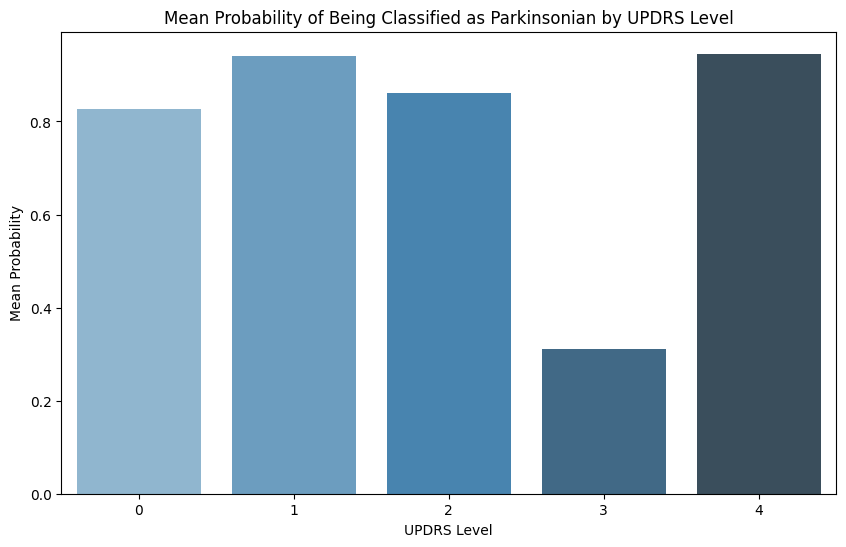

<ipython-input-6-ded3547fb947>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='UPDRS Level', y='Probability', data=df, palette='Pastel1')


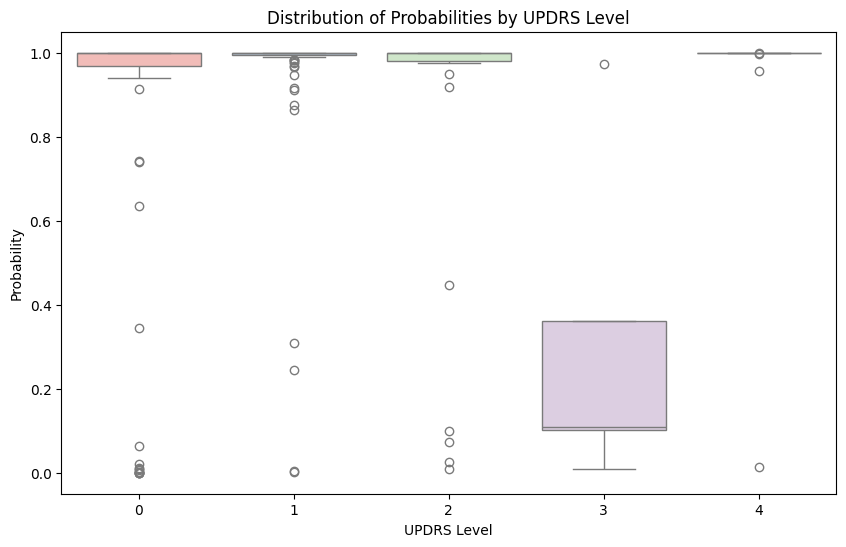

<ipython-input-6-ded3547fb947>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=levels, y=percentages_classified, palette='Oranges_d')


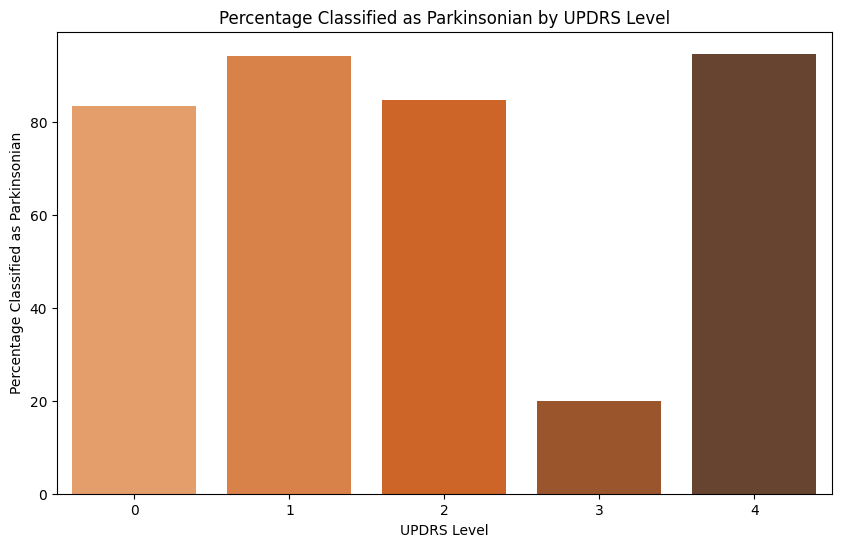

<ipython-input-6-ded3547fb947>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=levels, y=total_counts, palette='Greens_d')


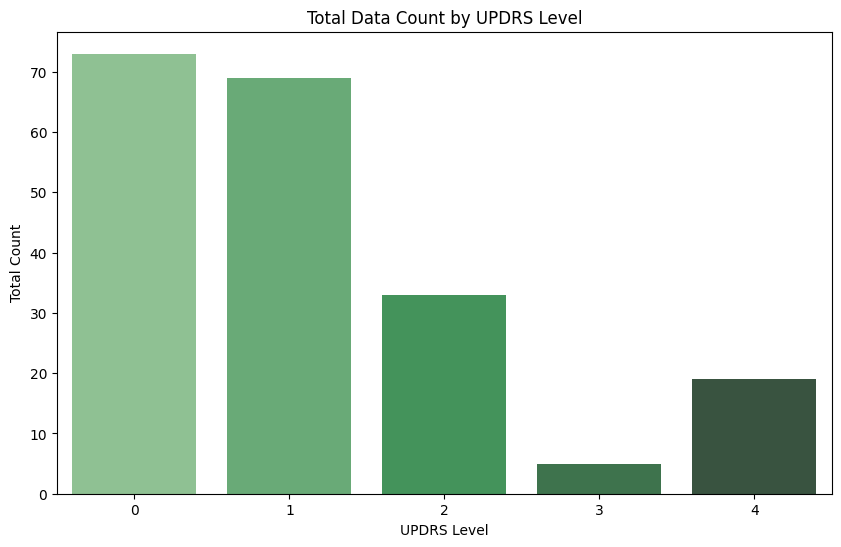

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_updrs_metrics(aggregated_updrs_metrics, probabilities_by_updrs):
    # Prepare data for plotting
    levels = list(aggregated_updrs_metrics.keys())
    total_counts = [aggregated_updrs_metrics[level]['total_count'] for level in levels]
    mean_probs = [aggregated_updrs_metrics[level]['mean_probability'] for level in levels]
    mean_logits = [aggregated_updrs_metrics[level]['mean_logit'] for level in levels]
    percentages_classified = [aggregated_updrs_metrics[level]['percentage_classified_as_parkinsonian'] for level in levels]

    # Bar chart for mean probabilities
    plt.figure(figsize=(10, 6))
    sns.barplot(x=levels, y=mean_probs, palette='Blues_d')
    plt.xlabel('UPDRS Level')
    plt.ylabel('Mean Probability')
    plt.title('Mean Probability of Being Classified as Parkinsonian by UPDRS Level')
    plt.show()

    # Boxplot for probabilities
    plt.figure(figsize=(10, 6))
    data = [(level, prob) for level, probs in probabilities_by_updrs.items() for prob in probs]
    df = pd.DataFrame(data, columns=['UPDRS Level', 'Probability'])
    sns.boxplot(x='UPDRS Level', y='Probability', data=df, palette='Pastel1')
    plt.xlabel('UPDRS Level')
    plt.ylabel('Probability')
    plt.title('Distribution of Probabilities by UPDRS Level')
    plt.show()

    # Bar chart for percentage classified as Parkinsonian
    plt.figure(figsize=(10, 6))
    sns.barplot(x=levels, y=percentages_classified, palette='Oranges_d')
    plt.xlabel('UPDRS Level')
    plt.ylabel('Percentage Classified as Parkinsonian')
    plt.title('Percentage Classified as Parkinsonian by UPDRS Level')
    plt.show()

    # Bar chart for total count
    plt.figure(figsize=(10, 6))
    sns.barplot(x=levels, y=total_counts, palette='Greens_d')
    plt.xlabel('UPDRS Level')
    plt.ylabel('Total Count')
    plt.title('Total Data Count by UPDRS Level')
    plt.show()

# Call the function after calculating metrics
plot_updrs_metrics(aggregated_updrs_metrics, probabilities_by_updrs)

In [7]:
# Nome del file per salvare tutti i risultati
results_filename = "results_AST_parallel2.txt"

# Scrivi tutti i risultati in un unico file
with open(results_filename, mode="w") as file:
    # Scrivi i risultati UPDRS
    file.write("===== Aggregated UPDRS Metrics Across Folds =====\n")
    for level, metrics in aggregated_updrs_metrics.items():
        file.write(f"UPDRS Level {level}:\n")
        file.write(f"  Total Count: {metrics['total_count']}\n")
        file.write(f"  Mean Probability (Parkinsonian): {metrics['mean_probability']:.4f}\n")
        file.write(f"  Percentage Classified as Parkinsonian: {metrics['percentage_classified_as_parkinsonian']:.2f}%\n")
        file.write("-" * 40 + "\n")

    # Scrivi le metriche medie sui fold
    file.write("\n===== Average Metrics Across Folds (Last Epoch Only) =====\n")
    file.write(f"Training Accuracy: {average_train_accuracy:.4f}\n")
    file.write(f"Validation Accuracy: {average_val_accuracy:.4f}\n")
    file.write(f"Training Precision: {average_train_precision:.4f}\n")
    file.write(f"Validation Precision: {average_val_precision:.4f}\n")
    file.write(f"Training Recall: {average_train_recall:.4f}\n")
    file.write(f"Validation Recall: {average_val_recall:.4f}\n")
    file.write(f"Training F1-Score: {average_train_f1:.4f}\n")
    file.write(f"Validation F1-Score: {average_val_f1:.4f}\n")
    file.write(f"Validation Sensitivity: {average_val_sensitivity:.4f}\n")
    file.write(f"Validation Specificity: {average_val_specificity:.4f}\n")

print(f"All results saved to {results_filename}")

All results saved to results_AST_parallel2.txt
